<a href="https://colab.research.google.com/github/Madhurima1997/Content-Based-Image-Retrieval-using-Autoencoder/blob/main/master_thesis_cbir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from glob import glob

In [ ]:
noOfClasses = 6
noOfImagesPerClass = []
paths= glob("/content/gdrive/My Drive/dataset/*")

def load_img():
    dataset=[]
    train=[]
    test=[]
    x_test=[]
    x_train=[]
    for i in range(noOfClasses):
        class_data=[]
        for file in glob((paths[i]+"/*.jpg")):
            img=cv2.imread(file)
            print(file)
            data=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            data=cv2.resize(data,(128,128))
            # data=image.img_to_array(data)
            class_data.append([data,i])
            
        dataset.extend(class_data) 
        noOfImagesPerClass.append(len(class_data))
        train_sec,test_sec = train_test_split(class_data,train_size=0.80,random_state=42)
        train.extend(train_sec)
        test.extend(test_sec)
    
    x_train = [row[0].reshape(1,128,128,1) for row in train]
    x_test = [row[0].reshape(1,128,128,1) for row in test]
    return dataset,train,test,x_train,x_test

In [ ]:
dataset,train,test,x_train,x_test = load_img()

/content/gdrive/My Drive/dataset/fox/392.jpg
/content/gdrive/My Drive/dataset/fox/3058.jpg
/content/gdrive/My Drive/dataset/fox/496.jpg
/content/gdrive/My Drive/dataset/fox/3416.jpg
/content/gdrive/My Drive/dataset/fox/2742.jpg
/content/gdrive/My Drive/dataset/fox/2081.jpg
/content/gdrive/My Drive/dataset/fox/3654.jpg
/content/gdrive/My Drive/dataset/fox/4643.jpg
/content/gdrive/My Drive/dataset/fox/2595.jpg
/content/gdrive/My Drive/dataset/fox/3030.jpg
/content/gdrive/My Drive/dataset/fox/818.jpg
/content/gdrive/My Drive/dataset/fox/4200.jpg
/content/gdrive/My Drive/dataset/fox/3434.jpg
/content/gdrive/My Drive/dataset/fox/1526.jpg
/content/gdrive/My Drive/dataset/fox/474.jpg
/content/gdrive/My Drive/dataset/fox/1878.jpg
/content/gdrive/My Drive/dataset/fox/2408.jpg
/content/gdrive/My Drive/dataset/fox/173.jpg
/content/gdrive/My Drive/dataset/fox/2241.jpg
/content/gdrive/My Drive/dataset/fox/151.jpg
/content/gdrive/My Drive/dataset/fox/4064.jpg
/content/gdrive/My Drive/dataset/fox/322

In [ ]:
print ('Total images in dataset: {}'.format(len(dataset)))

Total images in dataset: 4700


<BarContainer object of 6 artists>

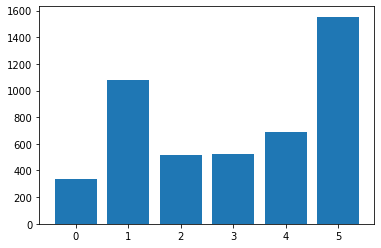

In [ ]:
plt.bar([0,1,2,3,4,5],height=noOfImagesPerClass)

In [ ]:
x_train[0][0].shape

(128, 128, 1)

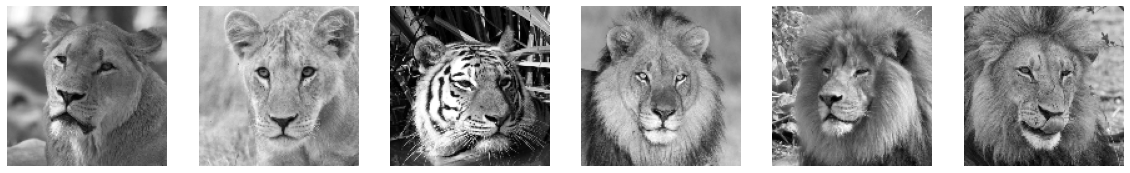

In [ ]:
import random

plt.figure(figsize=(20,20))

for i in range(6):
  plt.subplot(1,6,i+1)
  img=(random.choice(train))
  plt.imshow(img[0],cmap=plt.cm.gray)
  plt.axis('off')
plt.show()

In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print(x_train.shape, x_test.shape)

(3758, 1, 128, 128, 1, 1) (942, 1, 128, 128, 1, 1)


In [ ]:
x_train = np.reshape(x_train, (-1, 128, 128, 1))
x_test = np.reshape(x_test, (-1, 128, 128, 1))
print(x_train.shape, x_test.shape)

(3758, 128, 128, 1) (942, 128, 128, 1)


In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as K
import numpy as np

In [ ]:
def build(width, height, depth, filters=(32,32,64,64), latentDim=16):
  inputShape = (height, width, depth)
  chanDim = -1
  inputs = Input(shape=inputShape)
  x = inputs
  for f in filters:
    x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization(axis=chanDim)(x)
  volumeSize = K.int_shape(x)
  x = Flatten()(x)
  latent = Dense(latentDim, name="encoded")(x)
  x = Dense(np.prod(volumeSize[1:]))(latent)
  x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
  for f in filters[::-1]:
    x = Conv2DTranspose(f, (3, 3), strides=2,padding="same")(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization(axis=chanDim)(x)
  x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
  outputs = Activation("sigmoid", name="decoded")(x)
		# construct our autoencoder model
  autoencoder = Model(inputs, outputs, name="autoencoder")
		# return the autoencoder model
  return autoencoder

In [ ]:
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
def visualize_predictions(decoded, gt, samples=10):
  outputs=None
  for i in range(0,samples):
    original = (gt[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")
    output = np.hstack([original, recon])
    if outputs is None:
      outputs = output                       
    else:
      outputs = np.vstack([outputs, output])
  return outputs

In [ ]:
EPOCHS = 30
INIT_LR = 1e-3
BS = 25

print("[INFO] building autoencoder...")
autoencoder = build(128, 128, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt, metrics=['accuracy'])

[INFO] building autoencoder...


In [ ]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        

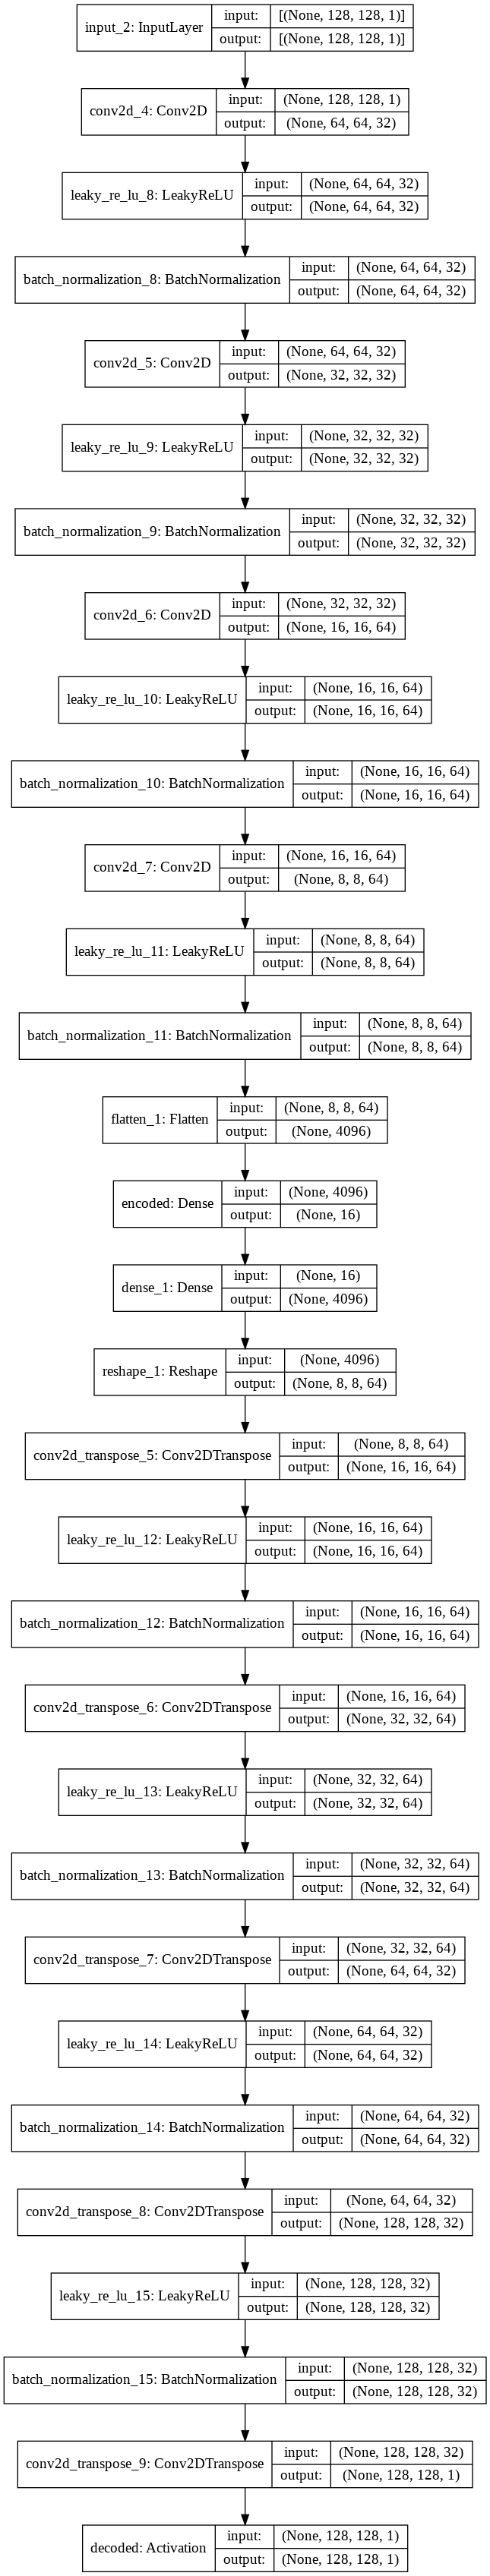

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='/content/gdrive/MyDrive/model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
H = autoencoder.fit(x_train, x_train,	validation_data=(x_test, x_test),	epochs=EPOCHS,batch_size=BS)

Epoch 1/30
151/151 [==============================] - 3s 21ms/step - loss: 0.0218 - accuracy: 0.0021 - val_loss: 0.0242 - val_accuracy: 0.0021
Epoch 2/30
151/151 [==============================] - 3s 21ms/step - loss: 0.0218 - accuracy: 0.0021 - val_loss: 0.0248 - val_accuracy: 0.0021
Epoch 3/30
151/151 [==============================] - 3s 21ms/step - loss: 0.0216 - accuracy: 0.0021 - val_loss: 0.0243 - val_accuracy: 0.0021
Epoch 4/30
151/151 [==============================] - 3s 20ms/step - loss: 0.0216 - accuracy: 0.0021 - val_loss: 0.0251 - val_accuracy: 0.0021
Epoch 5/30
151/151 [==============================] - 3s 20ms/step - loss: 0.0215 - accuracy: 0.0021 - val_loss: 0.0241 - val_accuracy: 0.0021
Epoch 6/30
151/151 [==============================] - 3s 21ms/step - loss: 0.0214 - accuracy: 0.0021 - val_loss: 0.0244 - val_accuracy: 0.0021
Epoch 7/30
151/151 [==============================] - 3s 21ms/step - loss: 0.0214 - accuracy: 0.0021 - val_loss: 0.0243 - val_accuracy: 0.0021

In [ ]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(x_test)
vis = visualize_predictions(decoded, x_test)
cv2.imwrite('/content/gdrive/My Drive/reconstruction-visualizations.png',vis)

[INFO] making predictions...


True

In [ ]:
from keras.models import model_from_json
model_json = autoencoder.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


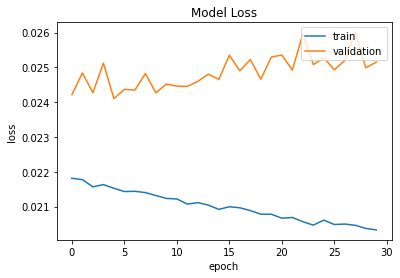

In [ ]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper right')
plt.show()

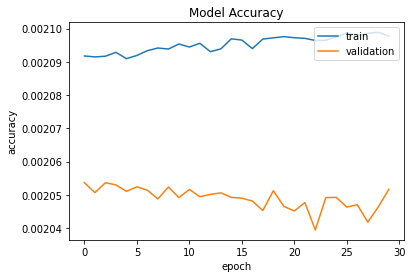

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper right')
plt.show()

In [ ]:
encoder = Model(inputs=autoencoder.input,	outputs=autoencoder.get_layer("encoded").output)

In [ ]:
codes = encoder.predict(x_train)

In [ ]:
codes.shape

(3758, 16)

In [ ]:
from sklearn.neighbors import NearestNeighbors
n_neigh = 5
nbrs = NearestNeighbors(n_neighbors=n_neigh, metric="cosine").fit(codes)

In [ ]:
def modelpredict(x_test):
    parameters = [[],[],[]]
    for i in range(len(x_test)):
        query_code = encoder.predict(x_test[i].reshape(1,128,128,1))
        distances, indices = nbrs.kneighbors(np.array(query_code))
        p,r,f = evaluate(train, test, indices, i)
        parameters[0].append(p)
        parameters[1].append(r)
        parameters[2].append(f)
    return parameters

In [ ]:
def evaluate(train,test,indices, query_index):
    correct = 0
    wrong = 0
    for i in indices[0]:
        if(train[i][1]==test[query_index][1]):
            correct+=1
        else:
            wrong+=1
    accuracy_precision = correct/(len(indices[0])+ 1e-9)
    recall = correct/noOfImagesPerClass[test[query_index][1]]
    f_score = (2 * accuracy_precision * recall) / (accuracy_precision + recall + 1e-9)
    return accuracy_precision, recall, f_score

In [ ]:
def evaluate_model(parameters):
    precision =  np.mean(parameters[0])
    recall = np.mean(parameters[1])
    f_score = np.mean(parameters[2])
    print("Model Accuracy: ",precision)

In [ ]:
parameters = modelpredict(x_test)
evaluate_model(parameters)

Model Accuracy:  0.4326963905716349


#Accuracy

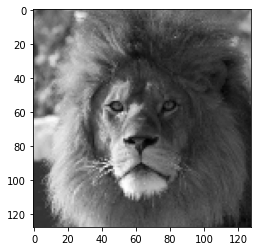

In [ ]:
query = x_test[560]
plt.imshow(query.reshape(128,128), cmap='gray');

In [ ]:
query_code = encoder.predict(query.reshape(1,128,128,1))
distances, indices = nbrs.kneighbors(np.array(query_code))
p,r,f = evaluate(train, test, indices, 560)
print("Accuracy: ",(p*100))

Accuracy:  19.999999996


In [ ]:
closest_images = x_train[indices[0]]
closest_images = closest_images.reshape(-1,128,128,1); print(closest_images.shape)

(5, 128, 128, 1)


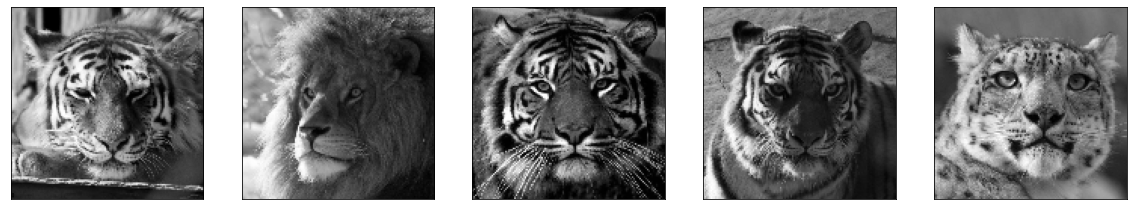

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(n_neigh):
    # display original
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

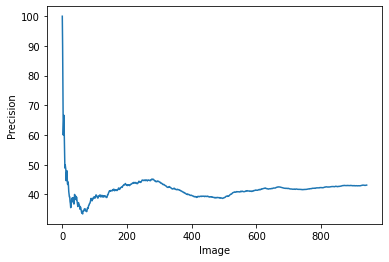

In [ ]:
import seaborn as sns
import numpy as np
xaxis = np.arange(len(parameters[0]))
csum = np.cumsum(parameters[0])
yaxis = (csum/(xaxis+1))*100
plt.plot(xaxis,yaxis)
plt.xlabel("Image")
plt.ylabel("Precision")
plt.show()

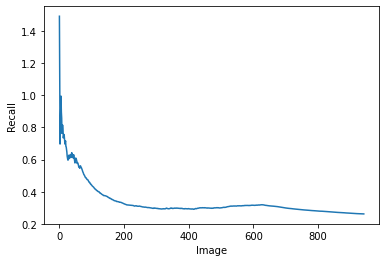

In [ ]:
xaxis = np.arange(len(parameters[1]))
csum = np.cumsum(parameters[1])
yaxis = (csum/(xaxis+1))*100
plt.plot(xaxis,yaxis)
plt.xlabel("Image")
plt.ylabel("Recall")
plt.show()